<a href="https://colab.research.google.com/github/zzhining/crawling/blob/main/%EC%9E%AC%EB%AC%B4%EC%A0%9C%ED%91%9C%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%A0%84%EC%B2%98%EB%A6%AC_with_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install OpenDartReader

In [ ]:
import OpenDartReader # 모듈 불러오기
my_api = "apikey" # API KEY 지정
dart = OpenDartReader(my_api) # OpenDartReader 객체 생성하기

# 재무제표 가져오기
특정 기업(삼성전자)의 2023년 재무제표 가져오기

In [ ]:
df = dart.finstate("삼성전자", 2023)
df.head()

# 필요한 정보만 가져오기

1. `account_nm` 컬럼의 값이 `['자산총계', '부채총계', '자본총계', '매출액', '영업이익', '당기순이익']`인 인스턴스만 추출
2. `["bsns_year", "account_nm", "fs_nm", "thstrm_amount", "frmtrm_amount", "bfefrmtrm_amount"] `컬럼만 추출

In [ ]:
ind_list = ['자산총계', '부채총계', '자본총계', '매출액', '영업이익', '당기순이익']
df = df.loc[df["account_nm"].isin(ind_list), ["bsns_year", "account_nm", "fs_nm", "thstrm_amount", "frmtrm_amount", "bfefrmtrm_amount"]]
df

3. `fs_nm`이 `연결재무제표`와 `재무제표` 두 종류가 있는 경우, `연결재무제표`만 남기기

In [ ]:
df = df[df['fs_nm'] == '연결재무제표']
df

# 컬럼명 변경
- 수집한 재무제표 연도에 기초해서 연도로 컬럼명 변경 <br>
(예): `bsns_year`= 2023년 재무제표 수집한 경우,
    - `thstrm_amount`: 당기금액(2023)
    - `frmtrm_amount`: 전기금액(2022)
    - `bfefrmtrm_amount`: 전전기금액(2021)

In [ ]:
year = df['bsns_year'].values[0]
# df = df.rename(columns ={'thstrm_amount': '2023', 'frmtrm_amount': '2022', 'bfefrmtrm_amount': '2021'})
df = df.rename(columns ={'thstrm_amount': year, 'frmtrm_amount': str(int(year)-1), 'bfefrmtrm_amount': str(int(year)-2)})
df.head()

# 불필요한 컬럼 제거
`bsns_year`, `fs_nm` 컬럼 삭제

In [ ]:
df = df.drop(['bsns_year', 'fs_nm'], axis=1)
df.head()

# 데이터 프레임 구조 변경
- `연도`,	`자산총계`,	`부채총계`,	`자본총계`,	`매출액`,	`영업이익`,	`당기순이익`의 컬럼을 갖도록 데이터 구조 변경
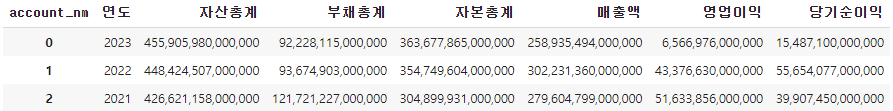
- `연도`순(과거 데이터가 위에 위치하도록) 정렬



In [ ]:
df = df.set_index('account_nm').T.reset_index().rename(columns = {'index': '연도'})
df = df.sort_values('연도')
df

# 데이터 변환
`['자산총계', '부채총계', '자본총계', '매출액', '영업이익', '당기순이익']` 컬럼의 데이터에 포함된 콤마(,)를 제거하고, 실수(float)형으로 변환

In [ ]:
for ind in ind_list:
    df[ind] = df[ind].apply(lambda x: x.replace(',', '')).astype(float)
df.head()

# 신규 컬럼 생성

1. `부채비율` = `부채총계` / `자본총계` * 100
2. `매출액증가율` = (당해연도 매출액 - 전년도 매출액) / (전년도 매출액) * 100
3. `영업이익증가율` = (당해연도 영업이익 - 전년도 영업이익) / (전년도 영업이익) * 100
3. `당기순이익증가율` = (당해연도 당기순이익 - 전년도 당기순이익) / (전년도 당기순이익) * 100
4. `ROA` = `당기순이익` / `자산총계` * 100
5. `ROE` = `당기순이익` / `평균자기자본`<br>
    `평균자기자본` = 당해연도 자본총계와 이전연도 자본총계의 평균

In [ ]:
df['부채비율'] = df['부채총계'] / df['자본총계'] * 100
df['매출액증가율'] = (df['매출액'].diff() / df['매출액'].shift(1)) * 100
df['영업이익증가율'] = (df['영업이익'].diff() / df['영업이익'].shift(1)) * 10
df['당기순이익증가율'] = (df['당기순이익'].diff() / df['당기순이익'].shift(1)) * 100
df['ROA'] = (df['당기순이익'] / df['자산총계']) * 100
average_equity = df['자본총계'].rolling(2).mean() # 평균 자기 자본
df['ROE'] = (df['당기순이익'] / average_equity) * 100
df

`매출액`, `영업이익`, `당기순이익`에 대해 `[흑자지속, 적자지속, 흑자전환, 적자전환]` 상태로 표시
- 신규 컬럼 생성: 예) `매출액 상태`
- 당해연도 증가율과 이전년도 증가율의 값을 기초로 판단
    - 예) (2022년 매출액 증가율 > 0) and (2023년 매출액 증가율 > 0) : 2023년의 `매출액 상태`는 `흑자지속`


In [ ]:
def add_finnce_state(data, col):
    data[col + "_상태"] = np.nan # 상태를 결측으로 초기화
    states = []
    values = data[col].values

    for i in range(len(values)):
        if i == 0:
            states.append('-')
        else:
            pre_value = values[i-1]
            cur_value = values[i]

            if cur_value > 0:
                if pre_value > 0:
                    states.append('흑자지속')
                else:
                    states.append('흑자전환')
            else:
                if pre_value > 0:
                    states.append('적자전환')
                else:
                    states.append('적자지속')

    data[col + "_상태"] = states
    return data

In [ ]:
add_finnce_state(df, "매출액증가율")
add_finnce_state(df, "영업이익증가율")
add_finnce_state(df, "당기순이익증가율")
df

# 여러 개의 데이터
- 지금까지 작업한 내용을 함수로 정리
- 9개 연도의 재무제표 데이터를 수집
- 여러 회사의 데이터를 수집하고, `회사명` 컬럼 추가

In [ ]:
def get_clean_report(df):
    ind_list = ['자산총계', '부채총계', '자본총계', '매출액', '영업이익', '당기순이익']
    df = df.loc[df["account_nm"].isin(ind_list), ["bsns_year", "account_nm", "fs_nm", "thstrm_amount", "frmtrm_amount", "bfefrmtrm_amount"]]
    df = df[df['fs_nm'] == '연결재무제표']
    year = df['bsns_year'].values[0]
    df = df.rename(columns ={'thstrm_amount': year, 'frmtrm_amount': str(int(year)-1), 'bfefrmtrm_amount': str(int(year)-2)})
    df = df.drop(['bsns_year', 'fs_nm'], axis=1)
    df = df.set_index('account_nm').T.reset_index().rename(columns = {'index': '연도'})

    for ind in ind_list:
        df[ind] = df[ind].apply(lambda x: x.replace(',', '')).astype(float)

    return df

In [ ]:
def add_new_column(df):
    df = df.sort_values('연도')
    df['부채비율'] = df['부채총계'] / df['자본총계'] * 100
    df['매출액증가율'] = (df['매출액'].diff() / df['매출액'].shift(1)) * 100
    df['영업이익증가율'] = (df['영업이익'].diff() / df['영업이익'].shift(1)) * 10
    df['당기순이익증가율'] = (df['당기순이익'].diff() / df['당기순이익'].shift(1)) * 100
    df['ROA'] = (df['당기순이익'] / df['자산총계']) * 100
    average_equity = df['자본총계'].rolling(2).mean() # 평균 자기 자본
    df['ROE'] = (df['당기순이익'] / average_equity) * 100

    df= add_finnce_state(df, "매출액증가율")
    df= add_finnce_state(df, "영업이익증가율")
    df=add_finnce_state(df, "당기순이익증가율")

    return df

In [ ]:
import pandas as pd
year = [2023, 2020, 2017]
for y in year:
    _df = dart.finstate("삼성전자", y)
    clean_df = get_clean_report(_df)
    try:
        merged_df = pd.merge(merged_df, clean_df, how = 'outer')
    except:
        merged_df = clean_df
merged_df

In [ ]:
final_df = add_new_column(merged_df)
final_df

In [ ]:
import seaborn as sns
sns.lineplot(x = final_df['연도'], y= final_df['매출액'])